# DL-Ops Assignment 3: Tiny-Imagenet

## Checking Avilable GPU

In [1]:
!nvidia-smi

Tue Feb 28 22:36:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   47C    P8    35W / 350W |    182MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [2]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy
from tqdm.auto import tqdm

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks

## device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Model Defination

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super().__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def ResNet18_cifar(num_classes=10):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=num_classes)

In [5]:
model_resnet = ResNet18_cifar(num_classes=200).to(device)

## Model summary

In [6]:
summary(model=model_resnet,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 200]            --                   True
├─Sequential (conv1)                     [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 112, 112]   9,472                True
│    └─BatchNorm2d (1)                   [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (2)                          [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─ResidualBlock (0)                 [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Sequen

## Getting Dataset with pytorch

### Downloading Dataset

In [7]:
from pathlib import Path

url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
# create a Path object with the path to the file
path = Path('tiny-imagenet-200.zip')

if path.is_file() == False:
  print("Downloding dataset...")
  !wget {url}
  print("Extracting 'tiny-imagenet-200.zip'...")
  !unzip -q 'tiny-imagenet-200.zip'
else:
  print("Skipping Downloding...")

Skipping Downloding...


In [8]:
print("Processing the Raw Extracted Data")
import io
import glob
import os
from shutil import move
from os.path import join
from os import rmdir

target_folder = './tiny-imagenet-200/val/'

val_dict = {}
try:
  with open(target_folder + 'val_annotations.txt', 'r') as f:
      for line in f.readlines():
          split_line = line.split('\t')
          val_dict[split_line[0]] = split_line[1]
          
  paths = glob.glob(target_folder + 'images/*')
  paths[0].split('/')[-1]
  for path in paths:
      file = path.split('/')[-1]
      folder = val_dict[file]
      if not os.path.exists(target_folder + str(folder)):
          os.mkdir(target_folder + str(folder))
          
  for path in paths:
      file = path.split('/')[-1]
      folder = val_dict[file]
      dest = target_folder + str(folder) + '/' + str(file)
      move(path, dest)
      
  os.remove('./tiny-imagenet-200/val/val_annotations.txt')
  rmdir('./tiny-imagenet-200/val/images')
except:
  print("Processing Done Before or unable to process")
print("Processing Step Done")

Processing the Raw Extracted Data
Processing Done Before or unable to process
Processing Step Done


In [9]:
from torchvision import transforms

normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
        )

# define transforms
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
])


train_dataset = torchvision.datasets.ImageFolder(
    root='tiny-imagenet-200/train',
    transform=transform,
)

test_dataset = torchvision.datasets.ImageFolder(
    root='tiny-imagenet-200/val',
    transform=transform,
)
train_dataset, test_dataset


(Dataset ImageFolder
     Number of datapoints: 100000
     Root location: tiny-imagenet-200/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ),
 Dataset ImageFolder
     Number of datapoints: 10000
     Root location: tiny-imagenet-200/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ))

### Vis. dataset (train dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


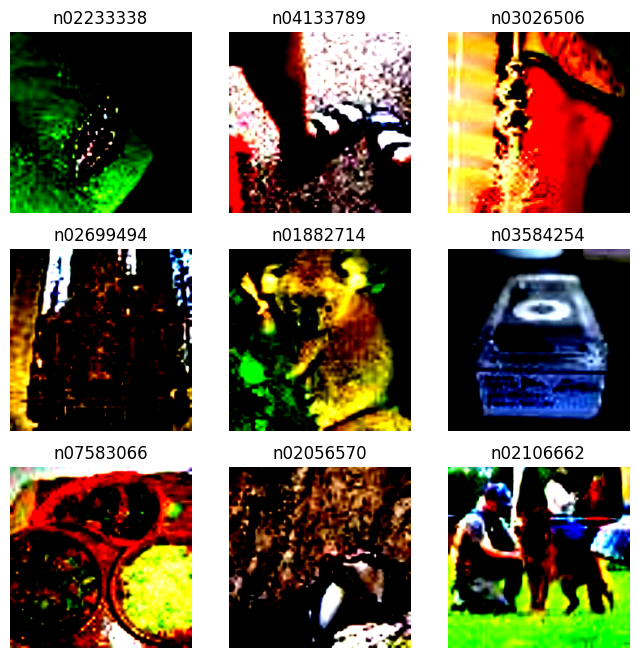

In [10]:
# randomly ploting image samples from the grayscale dataset
labels_map = train_dataset.class_to_idx  # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        img.permute(1, 2, 0)
    )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    # sub plot code ends
plt.show()
# NOTE: WARRING BECAUSE OF auto_transforms

### Converting dataset to dataloader

In [11]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 3125
Numbers of Batches in Test Dataloader: 313


## Models Training

### Plot loss curves of a model

In [12]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

### making training, testing steps, train model functions

#### set seeds function

In [13]:
### set seed function
def set_seed(seed: int = 42):
    """
    sets mannual seeds for both cpu and cuda
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


#### train step

In [14]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for idx,(X, y) in enumerate(tqdm(dataloader,desc="Training:")):  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
        # print("Model parms diff:")
        # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
        # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
        train_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)


#### test step

In [15]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)

#### training function

In [16]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    save_interval:int =10,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      save_interval (int): interval to save the model
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )
        # saving the model after every save_interal epochs
        if (epoch+1) % save_interval == 0:
            torch.save(model.state_dict(), f"models/model_{epoch+1}.pth")
        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

    # 5. return result dict
    return result_dict


## LOSS FUCNTIONS

### Center loss

In [17]:
import torch
import torch.nn as nn

def center_loss(y_preds:torch.Tensor,y_true:torch.Tensor,num_classes:int=200,feat_dim=200,device="cuda"):
    x = y_preds.to(device)
    y_true = y_true.to(device)
    centers = nn.Parameter(torch.randn(num_classes, feat_dim)).to(device=device)
    batch_size = x.size(0)
    distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, num_classes) + torch.pow(centers, 2).sum(dim=1, keepdim=True).expand(num_classes, batch_size).t()
    distmat.addmm_(x, centers.t(), beta=1, alpha=-2)
    classes = torch.arange(num_classes,dtype=torch.long).to(device)
    classes = classes.to(device)
    y_true = y_true.unsqueeze(1).expand(batch_size, num_classes)
    mask = y_true.eq(classes.expand(batch_size, num_classes))

    dist = distmat * mask.float()
    loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size
    return loss

#### train loop for model_resnet training

##### USING Optimizer Adam

In [19]:
# Hyperparms
lr = [1e-3] # learning rate
betas=[(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)

parms_combs = [(l,b,e,w_d) for l in lr for b in betas for e in eps for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 3

# init. loss function, accuracy function and optimizer
loss_fn = center_loss
acc_fn = Accuracy(task="multiclass", num_classes=200).to(device=device)


current exp / total Expirements: 1 / 1
Training with: lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Training::   0%|          | 0/3125 [00:01<?, ?it/s]

Epoch: 1 | train_loss: 200.1284 | train_acc: 0.0040 | test_loss: 199.1399 | test_acc: 0.0046


Training::   0%|          | 0/3125 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cc95a5360>
Traceback (most recent call last):
  File "/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/planck/anaconda3/envs/bikash/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cc95a5360>
Traceback (most recent call last):
  File "/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/planck/anaconda3/envs/bikash/lib/py

Epoch: 2 | train_loss: 196.9904 | train_acc: 0.0039 | test_loss: 195.2539 | test_acc: 0.0056


Training::   0%|          | 0/3125 [00:01<?, ?it/s]

Epoch: 3 | train_loss: 191.2061 | train_acc: 0.0043 | test_loss: 187.7480 | test_acc: 0.0059


Training::   0%|          | 0/3125 [00:01<?, ?it/s]

Epoch: 4 | train_loss: 184.7402 | train_acc: 0.0045 | test_loss: 183.1657 | test_acc: 0.0041


Training::   0%|          | 0/3125 [00:01<?, ?it/s]

Epoch: 5 | train_loss: 178.9814 | train_acc: 0.0041 | test_loss: 177.8362 | test_acc: 0.0055
total training time: 1352.498 sec.
LOSS & Accuracy Curves
lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


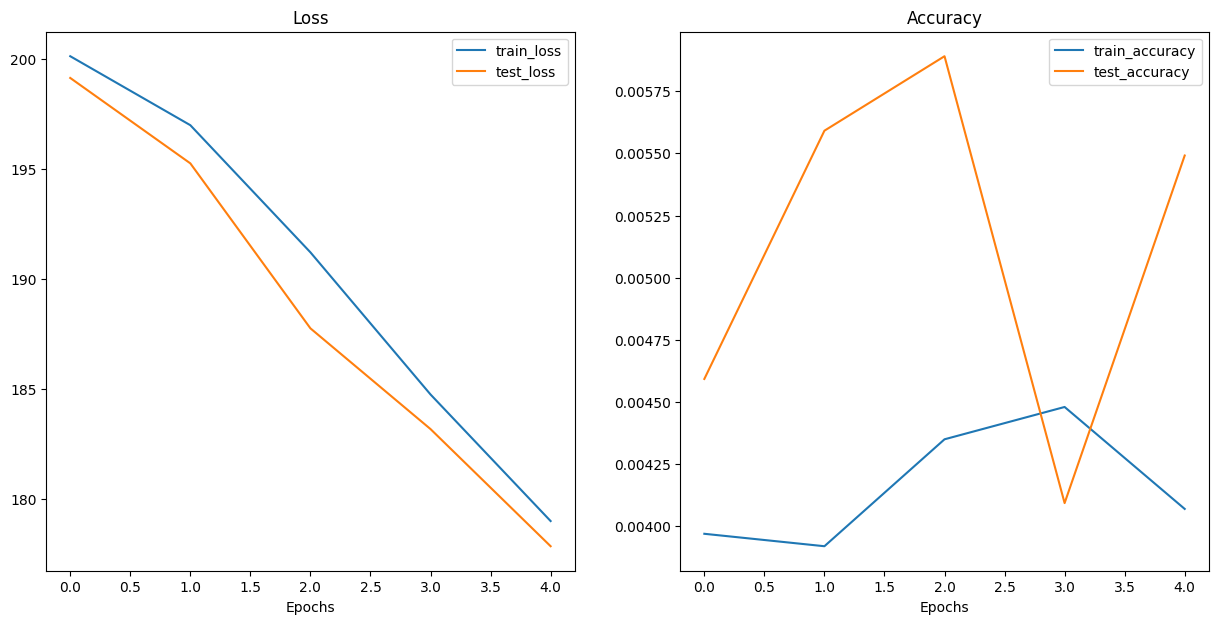

In [20]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  set_seed()
  model_resnet = ResNet18_cifar(num_classes=200).to(device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_resnet.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total Expirements: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  # train model
  model_resnet_results = train(
      model=model_resnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_interval = 10
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_resnet_results)
  cur+=1
  print()

### loading saved model and testing

In [21]:
# init. model
model_resnet = ResNet18_cifar(num_classes=200).to(device)

model_resnet.load_state_dict(torch.load('models/model_49.pth'))
model_resnet.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [30]:
model_resnet.eval()

# init. loss function, accuracy function and optimizer
loss_fn = center_loss
acc_fn = Accuracy(task="multiclass", num_classes=200).to(device=device)

test_loss, test_acc = testing_step(
            model=model_resnet,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )
print(f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

test_loss: 200.3084 | test_acc: 0.0050


## TESTING AREA

current exp / total Expirements: 1 / 1
Training with: lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/3 [00:00<?, ?it/s]

Training::   0%|          | 0/3125 [00:02<?, ?it/s]

Epoch: 1 | train_loss: 200.4105 | train_acc: 0.0048 | test_loss: 201.8093 | test_acc: 0.0047


Training::   0%|          | 0/3125 [00:02<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5107a493f0>
Traceback (most recent call last):
  File "/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/planck/anaconda3/envs/bikash/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5107a493f0>
Exception ignored in: Traceback (most recent call last):
  File "/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f

Epoch: 2 | train_loss: 200.0398 | train_acc: 0.0052 | test_loss: 199.2977 | test_acc: 0.0049


Training::   0%|          | 0/3125 [00:02<?, ?it/s]

Epoch: 3 | train_loss: 200.0742 | train_acc: 0.0047 | test_loss: 200.5856 | test_acc: 0.0050
total training time: 470.122 sec.
LOSS & Accuracy Curves
lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


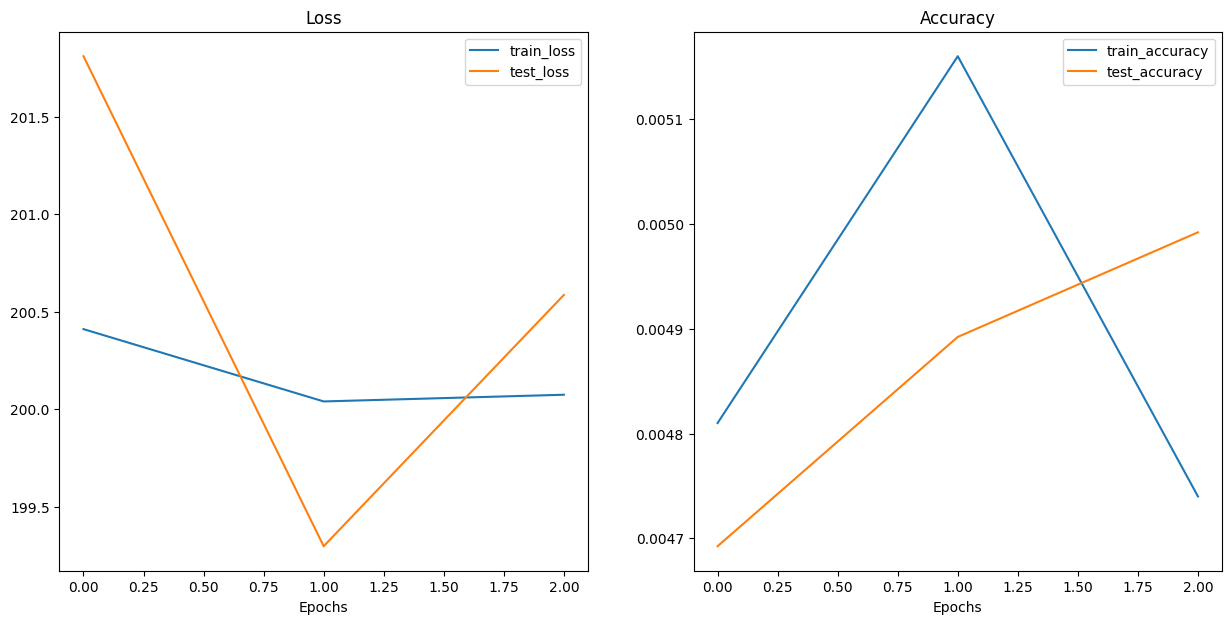

In [20]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  set_seed()
  model_resnet = ResNet18_cifar(num_classes=200).to(device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_resnet.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total Expirements: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  # train model
  model_resnet_results = train(
      model=model_resnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_interval = 10
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_resnet_results)
  cur+=1
  print()